In [1]:
import pickle
import itertools
import os
import random
import math
import time
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D

from libs.utils import *
from libs.generate_boxes import  *

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
def load_bbox(r_boxes, env, agent):
    step = 0
    done = False
    
    used_boxes, pred_pos, actions = [],[],[]
    history, remains, comb, s_orders = [],[],[],[]
    next_history, next_comb, next_remains, next_s_orders = [],[],[],[]
    
    while not done:
        state = env.container.copy()
        state_h = env.update_h().copy()
        step += 1
        k = min(K, len(r_boxes))
        
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c,next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                             env.height) for s_loc in s_loc_c])
        in_state, in_r_boxes = raw_to_input(state_h, s_order, r_boxes,
                                          num_max_remain, env.height)
        
        action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        print(len(loaded_mh_c), action_idx)
        
        history.append(in_state[action_idx])
        loaded_mh = get_loaded_mh(s_loc_c[action_idx], env.length,
                                 env.breadth, env.height)
        comb.append(loaded_mh)
        actions.append(action_idx)
        remains.append(in_r_boxes[action_idx])
        
        env.convert_state(next_cube_c[action_idx])
        
        next_state = env.container.copy()
        next_state_h = env.container_h.copy()
        next_history.append(next_state_h)
        
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
        
        used_boxes = used_boxes_c[action_idx]
        pred_pos = pred_pos_c[action_idx]
        
        if len(r_boxes) == 0:
            done = True
            next_remains.append(np.zeros((num_max_remain, 3)))
            next_comb.append(np.zeros((1, env.length, env.breadth, 2)))
            next_s_orders.append(np.zeros((1,1,3)))
        else:
            next_remains.append(r_boxes)
            k = min(K, len(r_boxes))
            selected = cbn_select_boxes(r_boxes[:n_candidates], k)
            s_order = get_selected_order(selected, k)
            s_loc_c,_,_,_,_,_ = get_selected_location(s_order, pred_pos,
                                                     used_boxes, next_state)
            loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length,env.breadth,
                                                  env.height) for s_loc in s_loc_c])
            next_comb.append(loaded_mh_c)
            next_s_orders.append(s_order)
            
            if np.sum(env.container_h != env.height) == 0:
                done = True
    
    tr_b = env.terminal_reward()
    return tr_b, step, history, used_boxes, remains, comb, pred_pos, actions, s_orders, next_history, next_comb, next_remains, next_s_orders, r_boxes

In [4]:
mi = 'U1'; t='PP'
with open('data/preprocessed_packing/'+mi + '_'+ t +'_r.pickle', 'rb') as handle: 
    boxes_multi = pickle.load(handle)
for i in range(len(boxes_multi)):
    boxes_multi[i] = boxes_multi[i][:,:3]//10

bboxes = np.load('data/preprocessed_pcked/bboxes1.npy')
bboxes = bboxes[:, :, :, :, 0]
for i in range(len(boxes_multi)):
    if np.sum(boxes_multi[i][:,0]>198) or np.sum(boxes_multi[i][:,1]>114) or np.sum(boxes_multi[i][:,2]>110):
        print('n', i)

In [5]:
len(boxes_multi[0]), boxes_multi[0]

(32,
 array([[56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24]], dtype=int64))

In [6]:
class ActorCritic_UseCNN(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(ActorCritic_UseCNN, self).__init__()
        
        self.case_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                               padding='valid', input_shape=state_size)
        self.case_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                               padding='valid')
        
        self.select_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                 padding='valid', input_shape=selected_size)
        self.select_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                 padding='valid')
        
        cs_size = state_size[:2] + (state_size[2] + selected_size[2], )
        self.cs_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                             padding='valid', input_shape=cs_size)
        self.cs_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                             padding='valid')
        
        self.remain_cnn1 = Conv1D(filters=32, kernel_size=2, activation='relu',
                                 padding='same', input_shape=remain_size)
        self.remain_cnn2 = Conv1D(filters=32, kernel_size=2, activation='relu',
                                 padding='same')
        
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.out = Dense(output_size)
    
    def call(self, cb_list):
        c,s,r = cb_list[0], cb_list[1], cb_list[2]
        cs = tf.concat([c,s],-1)
        
        c = self.case_cnn1(c)
        c = MaxPooling2D(pool_size=(2,2))(c)
        c = self.case_cnn2(c)
        c = MaxPooling2D(pool_size=(2,2))(c)
        c = Flatten()(c)
        
        s = self.select_cnn1(s)
        s = MaxPooling2D(pool_size=(2,2))(s)
        s = self.select_cnn2(s)
        s = MaxPooling2D(pool_size=(2,2))(s)
        s = Flatten()(s)
        
        cs = self.cs_cnn1(cs)
        cs = MaxPooling2D(pool_size=(2,2))(cs)
        cs = self.cs_cnn2(cs)
        cs = MaxPooling2D(pool_size=(2,2))(cs)
        cs = Flatten()(cs)
        
        r = self.remain_cnn1(r)
        r = self.remain_cnn2(r)
        r = MaxPooling1D(pool_size=1)(r)
        r = Flatten()(r)
        
        x = concatenate([c,s,cs,r])
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        q = self.out(x)
        return q

In [7]:
class ActorCritic_ExceptCNN(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(ActorCritic_ExceptCNN, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1 * b1 * k1, )
        self.case_dnn1 = Dense(256, activation='relu', input_shape = self.state_size)
        self.case_dnn2 = Dense(256, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2 * b2 * k2, )
        self.select_dnn1 = Dense(256, activation='relu', 
                                 input_shape = self.state_size)
        self.select_dnn2 = Dense(256, activation='relu')
        
        self.cs_size = (l1*b1*k1 + l2*b2*k2, )
        self.cs_dnn1 = Dense(256, activation='relu', input_shape = self.cs_size)
        self.cs_dnn2 = Dense(256, activation='relu')
        
        r, k = remain_size
        self.remain_size = (r*k, )
        self.remain_dnn1 = Dense(256, activation='relu', 
                                 input_shape=self.remain_size)
        self.remain_dnn2 = Dense(256, activation='relu')
        
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(256, activation='relu')
        self.fc3 = Dense(128, activation='relu')
        self.fc_out = Dense(output_size)
        
    def call(self, cb_list):
        c,s,r = cb_list[0], cb_list[1], cb_list[2]
        
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        cs = tf.concat([c,s], -1)
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        cs = self.cs_dnn1(cs)
        cs = self.cs_dnn2(cs)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        x = concatenate([c,s,cs,r])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        q = self.fc_out(x)
        return q

In [8]:
class ActorCritic_OnlyDense(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(ActorCritic_OnlyDense, self).__init__()
        
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.out = Dense(output_size)
        
    def call(self, cb_list):
        c,s,r = cb_list[0], cb_list[1], cb_list[2]
        cs = tf.concat([c,s], -1)
        
        c = Flatten()(c)
        s = Flatten()(s)
        cs = Flatten()(cs)
        r = Flatten()(r)
        
        x = concatenate([c,s,cs,r])
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        q = self.out(x)
        
        return q

In [9]:
class ActorCriticAgent:
    def __init__(self, L=20,B=20,H=20,n_remains=5,lr=1e-8,gamma=0.99,model_num=1):
        
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size = (n_remains, 3)
        self.output_size = 1
        
        self.gamma = gamma
        self.lr = lr
        
        if model_num == 0: #Use CNN
            self.actor = ActorCritic_UseCNN(self.state_size, self.selected_size,
                                           self.remain_size, self.output_size)
            self.critic = ActorCritic_UseCNN(self.state_size, self.selected_size,
                                            self.remain_size, self.output_size)
        elif model_num == 1: #Use DNN
            self.actor = ActorCritic_ExceptCNN(self.state_size, self.selected_size,
                                              self.remain_size, self.output_size)
            self.critic = ActorCritic_ExceptCNN(self.state_size, self.selected_size,
                                               self.remain_size, self.output_size)
        else: #Use Small DNN
            self.actor = ActorCritic_OnlyDense(self.state_size, self.selected_size,
                                              self.remain_size, self.output_size)
            self.critic = ActorCritic_OnlyDense(self.state_size, self.selected_size,
                                               self.remain_size, self.output_size)
        
        self.memory = deque(maxlen=500)
        
        self.actor_optimizer = Adam(self.lr)
        self.critic_optimizer = Adam(self.lr)
        self.avg_actor_loss, self.avg_critic_loss = 0, 0
        
    def get_action(self, state, s_locs, r_boxes):
        actor = self.actor([state, s_locs, r_boxes])
        print(actor)
        argmax_idx = np.where(actor == tf.math.reduce_max(actor))
        action_idx = argmax_idx[0][0]
        return action_idx
    
    def append_sample(self, history, s_boxes, remains, action, reward, last, t_history, t_s_boxes, t_remains):
        self.memory.append(( history, s_boxes, remains, action, reward, last, t_history, t_s_boxes, t_remains))
        
    def train(self):
        batch = random.sample(self.memory, len(self.memory))
        
        history = np.array([sample[0] for sample in batch])
        s_boxes = np.array([sample[1] for sample in batch])
        remains = np.array([sample[2] for sample in batch])
        action = np.array([sample[3] for sample in batch])
        reward = np.array([sample[4] for sample in batch])
        dones = np.array([sample[5] for sample in batch])
        next_history = [sample[6] for sample in batch]
        next_s_boxes = [sample[7] for sample in batch]
        next_remains = [sample[8] for sample in batch]
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            actor = self.actor([history, s_boxes, remains])
            value = self.critic([history, s_boxes, remains])
            
            print('actor')
            print(actor)
            print('value')
            print(value)
            
            targets = []
            action_idx = np.stack([np.arange(len(self.memory)),action],axis=1)
            print('action')
            print(action)
            print('action-idx')
            print(action_idx)
            acts = tf.gather_nd(actor, action_idx, batch_dims=0, name=None)
            predicts = tf.gather_nd(value, action_idx, batch_dims=0, name=None)
            
            for i in range(len(self.memory)):
                next_value = self.critic([next_history[i],next_s_boxes[i],
                                         next_remains[i]])
                next_max_value = tf.math.reduce_max(next_value)
                targets.append([(1-0.75)*reward[i] + (1-dones[i])*0.75*next_max_value])
            
            targets = np.array(targets)
            actor_loss = tf.reduce_mean(tf.square(targets - acts))
            critic_loss = tf.reduce_mean(tf.square(targets - predicts))
            
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
        
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads,
                                                self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads,
                                                 self.critic.trainable_variables))

In [10]:
num_episode = 1000
env1 = Bpp3DEnv(198, 114, 110, bboxes[0])
env2 = Bpp3DEnv(198, 114, 110, bboxes[1])
env3 = Bpp3DEnv(198, 114, 110, bboxes[2])
env4 = Bpp3DEnv(198, 114, 110, bboxes[3])
env_all = [env1, env2, env3, env4]

tr_l, h_fill, avg_loss_l,history_eps,used_boxes_eps  = [],[],[],[],[]

num_max_boxes = 100 #len(boxes_multi)
K = 3
n_candidates = 3 #4
num_max_remain = num_max_boxes #-K
agent = ActorCriticAgent(L=198, B=114, H=110, n_remains = num_max_remain,  
                 lr=1e-4, gamma = 0.99, model_num = 1)
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

(array([  0,   0,   0, ..., 197, 197, 197], dtype=int64), array([  0,   0,   0, ..., 113, 113, 113], dtype=int64), array([  0,   1,   2, ..., 107, 108, 109], dtype=int64))
[[  0   0   0]
 [  0   0   1]
 [  0   0   2]
 ...
 [197 113 107]
 [197 113 108]
 [197 113 109]]
(array([  0,   0,   0, ..., 197, 197, 197], dtype=int64), array([113, 113, 113, ..., 113, 113, 113], dtype=int64), array([  0,   1,   2, ..., 107, 108, 109], dtype=int64))
[[  0 113   0]
 [  0 113   1]
 [  0 113   2]
 ...
 [197 113 107]
 [197 113 108]
 [197 113 109]]
(array([  0,   0,   0, ..., 197, 197, 197], dtype=int64), array([  0,   0,   0, ..., 113, 113, 113], dtype=int64), array([  0,   1,   2, ..., 107, 108, 109], dtype=int64))
[[  0   0   0]
 [  0   0   1]
 [  0   0   2]
 ...
 [197 113 107]
 [197 113 108]
 [197 113 109]]
(array([  0,   0,   0, ..., 197, 197, 197], dtype=int64), array([  0,   0,   0, ..., 113, 113, 113], dtype=int64), array([ 0,  1,  2, ..., 46, 47, 48], dtype=int64))
[[  0   0   0]
 [  0   0   1]


### DNN

In [10]:
len(boxes_multi[6])

110

In [24]:
st=time.time()
boxes_all = np.array(boxes_multi)[6].copy()
r_boxes = boxes_all.copy()
used_boxes, predicts, h_results, h_idx = [], [], [], []

while len(r_boxes) > 0:
    print('==================', len(used_boxes), r_boxes.shape)
    bbox_results = []
    for i in range(4):
        env_t = time.time()
        (env_all[i]).reset()
        r = load_bbox(r_boxes[:num_max_remain], env_all[i], agent)
        print(i, r[0], len(r[3]), time.time()-env_t)
        bbox_results.append(r)
    idx = np.argmax([bbox_results[0][0],bbox_results[1][0],bbox_results[2][0],bbox_results[3][0]])    
    tr_b, sp, history, u_b, remains, comb, pred_pos, actions, s_orders, \
        t_history, t_combs, t_remains, t_s_orders, r_b = bbox_results[idx]
    if len(u_b)==0:
          break
    h_results.append(bbox_results)
    h_idx.append(idx)
    used_boxes = used_boxes + u_b
    r_boxes = get_remain(used_boxes, boxes_all)

h_path = [r[i] for r,i in zip(h_results,h_idx) ]
print(time.time() - st)

C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


================== 0 (110, 3)
0 0.8095783446121811 80 124.39483594894409
1 0.49514905090126327 100 109.55773162841797
2 0.8433107756376887 60 111.80557465553284
3 0.6615595122929031 100 141.82831072807312
================== 60 (50, 3)
0 0.6946382092660073 39 70.25005078315735
1 0.46683916418429694 50 58.37400579452515
2 0.596911330904043 34 69.96434688568115
3 0.6237351949172484 50 69.4072654247284
================== 99 (11, 3)
0 0.5826965122332118 11 13.79208517074585
1 0.21296340588375987 11 10.1793794631958
2 0.5885823355891029 8 13.54920482635498
3 0.2845364778065382 11 12.444088220596313
================== 107 (3, 3)
0 0.15891723060905777 3 2.2732062339782715
1 0.058080928877389054 3 1.5712800025939941
2 0.22071837584591358 3 2.4602882862091064
3 0.07760085758360133 3 2.077000379562378
813.944432258606


### Simple DNN

In [12]:
agent = ActorCriticAgent(L=198, B=114, H=110, n_remains = num_max_remain,  
                 lr=1e-4, gamma = 0.99, model_num = 2)
st=time.time()
boxes_all = np.array(boxes_multi)[0].copy()
r_boxes = boxes_all.copy()
used_boxes, predicts, h_results, h_idx = [], [], [], []

while len(r_boxes) > 0:
    print('==================', len(used_boxes), r_boxes.shape)
    bbox_results = []
    for i in range(4):
        env_t = time.time()
        (env_all[i]).reset()
        r = load_bbox(r_boxes[:num_max_remain], env_all[i], agent)
        print(i, r[0], len(r[3]), time.time()-env_t)
        bbox_results.append(r)
    idx = np.argmax([bbox_results[0][0],bbox_results[1][0],bbox_results[2][0],bbox_results[3][0]])    
    tr_b, sp, history, u_b, remains, comb, pred_pos, actions, s_orders, \
        t_history, t_combs, t_remains, t_s_orders, r_b = bbox_results[idx]
    if len(u_b)==0:
          break
    h_results.append(bbox_results)
    h_idx.append(idx)
    used_boxes = used_boxes + u_b
    r_boxes = get_remain(used_boxes, boxes_all)

h_path = [r[i] for r,i in zip(h_results,h_idx) ]
print(time.time() - st)

C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


================== 0 (32, 3)
0 0.8475585632483081 8 38.4779531955719
1 0.6405340175251679 21 46.28002190589905
2 0.5885823355891029 4 45.76432251930237
3 0.597746228462363 12 49.53763794898987
================== 8 (24, 3)
0 0.7288703800104113 10 32.56816840171814
1 0.5668369898458394 24 30.65289831161499
2 0.5229914974839494 4 29.879032611846924
3 0.5853008079065025 18 32.51314330101013
================== 18 (14, 3)
0 0.7046330036439354 12 19.903568267822266
1 0.30045008806070755 14 15.801273107528687
2 0.48932847475273294 6 17.659698247909546
3 0.40142581989001314 14 19.529933214187622
================== 30 (2, 3)
0 0.1174388339406559 2 2.0728018283843994
1 0.04292144115152965 2 1.343639612197876
2 0.16310949158424431 2 2.2941901683807373
3 0.05734654569857331 2 1.730747938156128
386.0141727924347


### Fix DNN

In [10]:
agent = ActorCriticAgent(L=198, B=114, H=110, n_remains = num_max_remain,  
                 lr=1e-4, gamma = 0.99, model_num = 2)
st=time.time()
boxes_all = np.array(boxes_multi)[0].copy()
r_boxes = boxes_all.copy()
used_boxes, predicts, h_results, h_idx = [], [], [], []

while len(r_boxes) > 0:
    print('==================', len(used_boxes), r_boxes.shape)
    bbox_results = []
    for i in range(4):
        env_t = time.time()
        (env_all[i]).reset()
        r = load_bbox(r_boxes[:num_max_remain], env_all[i], agent)
        print(i, r[0], len(r[3]), time.time()-env_t)
        bbox_results.append(r)
    idx = np.argmax([bbox_results[0][0],bbox_results[1][0],bbox_results[2][0],bbox_results[3][0]])    
    tr_b, sp, history, u_b, remains, comb, pred_pos, actions, s_orders, \
        t_history, t_combs, t_remains, t_s_orders, r_b = bbox_results[idx]
    if len(u_b)==0:
          break
    h_results.append(bbox_results)
    h_idx.append(idx)
    used_boxes = used_boxes + u_b
    r_boxes = get_remain(used_boxes, boxes_all)

h_path = [r[i] for r,i in zip(h_results,h_idx) ]
print(time.time() - st)

C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


================== 0 (32, 3)
0 0.8475585632483081 8 28.930346250534058
1 0.6405340175251679 21 34.819469928741455
2 0.5885823355891029 4 31.92595362663269
3 0.597746228462363 12 34.97011733055115
================== 8 (24, 3)
0 0.7288703800104113 10 26.787119150161743
1 0.5668369898458394 24 26.13207221031189
2 0.5229914974839494 4 21.266125917434692
3 0.6426473536050757 20 29.550524473190308
================== 18 (14, 3)
0 0.7046330036439354 12 19.469447374343872
1 0.30045008806070755 14 12.370128393173218
2 0.48932847475273294 6 13.504954814910889
3 0.40142581989001314 14 16.080023527145386
================== 30 (2, 3)
0 0.1174388339406559 2 1.917844533920288
1 0.04292144115152965 2 1.037506341934204
2 0.16310949158424431 2 2.120326280593872
3 0.05734654569857331 2 1.44134521484375
302.33458280563354


### CNN

In [27]:
agent = ActorCriticAgent(L=198, B=114, H=110, n_remains = num_max_remain,  
                 lr=1e-4, gamma = 0.99, model_num = 0)
st=time.time()
boxes_all = np.array(boxes_multi)[6].copy()
r_boxes = boxes_all.copy()
used_boxes, predicts, h_results, h_idx = [], [], [], []

while len(r_boxes) > 0:
    print('==================', len(used_boxes), r_boxes.shape)
    bbox_results = []
    for i in range(4):
        env_t = time.time()
        (env_all[i]).reset()
        r = load_bbox(r_boxes[:num_max_remain], env_all[i], agent)
        print(i, r[0], len(r[3]), time.time()-env_t)
        bbox_results.append(r)
    idx = np.argmax([bbox_results[0][0],bbox_results[1][0],bbox_results[2][0],bbox_results[3][0]])    
    tr_b, sp, history, u_b, remains, comb, pred_pos, actions, s_orders, \
        t_history, t_combs, t_remains, t_s_orders, r_b = bbox_results[idx]
    if len(u_b)==0:
          break
    h_results.append(bbox_results)
    h_idx.append(idx)
    used_boxes = used_boxes + u_b
    r_boxes = get_remain(used_boxes, boxes_all)

h_path = [r[i] for r,i in zip(h_results,h_idx) ]
print(time.time() - st)

C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


================== 0 (110, 3)
0 0.8095783446121811 80 133.1771857738495
1 0.49514905090126327 100 113.90047287940979
2 0.8433107756376887 60 109.11698985099792
3 0.6615595122929031 100 140.6267967224121
================== 60 (50, 3)
0 0.6946382092660073 39 70.16746735572815
1 0.46683916418429694 50 58.120633602142334
2 0.596911330904043 34 71.50616526603699
3 0.6237351949172484 50 72.44109153747559
================== 99 (11, 3)
0 0.5826965122332118 11 14.556462287902832
1 0.21296340588375987 11 11.193868398666382
2 0.5885823355891029 8 14.303203344345093
3 0.2845364778065382 11 13.278125762939453
================== 107 (3, 3)
0 0.15891723060905777 3 2.38696026802063
1 0.058080928877389054 3 1.7405214309692383
2 0.22071837584591358 3 2.6110823154449463
3 0.07760085758360133 3 2.0998306274414062
831.2544765472412


### Train

In [36]:
#agent = ActorCriticAgent(L=198, B=114, H=110, n_remains = num_max_remain,  
                 #lr=1e-4, gamma = 0.99, model_num = 1)

avg_actor_loss, avg_critic_loss = [], []
for e in range(2, num_episode):
    st=time.time()
    step = 0
    idx = e % len(boxes_multi)
    boxes_all = np.array(boxes_multi)[idx].copy()
    r_boxes = boxes_all.copy()
    print(r_boxes)
    
    used_boxes, predicts, h_results, h_idx = [], [], [], []
    
    while len(r_boxes) > 0:
        print('==================', len(used_boxes), r_boxes.shape)
        bbox_results = []
        for i in range(4):
            env_t = time.time()
            (env_all[i]).reset()
            r = load_bbox(r_boxes[:num_max_remain], env_all[i], agent)
            print('')
            print(i, r[0], len(r[3]), time.time() - env_t)
            bbox_results.append(r)
        idx = np.argmax([bbox_results[0][0],bbox_results[1][0],bbox_results[2][0],bbox_results[3][0]])    
        tr_b, sp, history, u_b, remains, comb, pred_pos, actions, s_orders, \
            next_history, next_comb, next_remains, next_s_orders, r_b = bbox_results[idx]
        
        if len(u_b)==0: 
            print('used boxes = 0')
            r_boxes = get_remain(r_boxes[:num_max_remain], r_boxes)
            continue
            
        h_results.append(bbox_results)
        h_idx.append(idx)
        step = step + sp
        used_boxes = used_boxes + u_b
        r_boxes = get_remain(used_boxes, boxes_all)
        
        disused_boxes = get_remain(used_boxes, boxes_all)
        termianl_penalty =  np.sum(disused_boxes[:,0]*disused_boxes[:,1]*disused_boxes[:,2])/(198*114*110)
        terminal_reward = tr_b - 4*termianl_penalty
        
        tr_l.append(terminal_reward)
        h_fill.append(tr_b)
        
        if len(r_boxes) != 0:
            is_last = False 
            N = len(history)
            for i in range(N):
                if i == N-1: 
                    is_last=True
                reward=(agent.gamma**(N-i-1)) * terminal_reward 
                in_next_history, in_next_remains = raw_to_input(next_history[i],
                                                               next_s_orders[i],
                                                               next_remains[i],
                                                               num_max_remain, 110)
                agent.append_sample(history[i], comb[i], remains[i], actions[i],
                                   reward, is_last, in_next_history,
                                   next_comb[i], in_next_remains)
            agent.train()
            avg_actor_loss.append(agent.avg_actor_loss / float(step))
            avg_critic_loss.append(agent.avg_critic_loss / float(step))
    
    
    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "reward(): {:.3f}, {:.3f}| ".format(tr_b, terminal_reward)
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss, agent.avg_critic_loss = 0,0
    agent.memory.clear()

C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


[[53 28 12]
 [53 28 12]
 [53 28 12]
 [53 28 12]
 [53 28 12]
 [53 28 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]]
================== 0 (48, 3)
tf.Tensor([[-1.9907607]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.0973146]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.8609568]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9468144]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.983915]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.957685]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.0152779]], shape=(1, 1), dt

tf.Tensor([[-2.3093784]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.4852052]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.4223223]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.5942569]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.716465]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.579324]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.227635]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2237737]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-2.2296739]
 [-2.2296739]
 [-2.2296739]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-2.2315583]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2308207]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2308426]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2300277]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2272696]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2295642]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.227817]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2290611]], shape

================== 44 (18, 3)
tf.Tensor([[-0.3242054]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.34551919]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.35685956]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.39713305]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.11567467]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.1153359]], shape=(1, 1), dtype=float32)
1 0

0 0.5578344612181155 12 21.86178755760193
tf.Tensor([[-0.10241508]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.11054165]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.06879604]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.1746919]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.19960451]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.11157941]], shape=(1, 1), dtype=float32)
1 0

1 0.3058152682046487 18 16.247787475585938
tf.Tensor([[-0.36359727]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.40918684]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.13053237]], shape=(1, 1), dtype

tf.Tensor([[0.2391662]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.21230744]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.17393853]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.2902596]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.25668415]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.24843581]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.3071164]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.3229969]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[0.36377013]
 [0.36377013]
 [0.36377013]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[0.20422225]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.42931628]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[0.43004715]
 [0.43004715]
 [0.43004715]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[0.43287417]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.42760155]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.4263793]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.4296011]], shape=(1, 1), dtype=float32)
1 0
tf.T

tf.Tensor([[0.11969763]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.1387998]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.15452519]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.17044753]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.16122633]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.1449501]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.20182088]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.22455874]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.20531842]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[0.31832525]
 [0.289555  ]
 [0.31084314]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[0.43708903]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[0.3164828 ]
 [0.3164828 ]
 [0.42450443]
 [0.42450443]
 [0.3164828 ]
 [0.42450443]], shape=(6, 1), dtype=float32)
6 2
tf.Tensor(
[[0.3916051]
 [0.3916051]
 [0.3916051]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[0.37240592]
 [0.37240592]
 [0.37240592]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[0.3690219

tf.Tensor([[0.01527094]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.00731598]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.00595425]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.00881486]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.00843637]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.011088]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.01257469]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.01273318]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.01286854]], shape=(1, 1), dtype=float32)
1 0

1 0.5900328325107086 19 46.025493144989014
tf.Tensor([[-0.19739355]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.10927688]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.06115092]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.14852689]
 [-0.01567073]
 [ 0.2756263 ]], shape=(3, 1), dtype=float32)
3 2
tf.Tensor(
[[-0.04118152]
 [-0.04118152]
 [-0.04118152]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.04540111]
 [-0.04540111]
 [-0.04540111]
 [-0.0454

tf.Tensor(
[[-0.71988577]
 [-0.71988577]
 [-0.71988577]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-0.71622086]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7213805]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7172455]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7184661]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7155356]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7134472]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7144538]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7137111]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.71025395]], shape=(1, 1), dtype=float32)
1 0

2 0.6313841170686564 4 53.08221769332886
tf.Tensor(
[[-0.25784764]
 [-0.22032791]
 [-0.26308036]], shape=(3, 1), dtype=float32)
3 1
tf.Tensor(
[[-0.35542598]
 [-0.35542598]
 [-0.35542598]
 [-0.35542598]
 [-0.35542598]
 [-0.35542598]], shape=(6, 1), dtype=float32)
6 0
tf.Tensor(
[[-0.43894574]
 [-0.43894574]
 [-0.43894574]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.

tf.Tensor([[-1.3912418]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3873054]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3904226]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3922228]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3893583]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3883667]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3888152]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.385929]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.385509]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3843479]], shape=(1, 1), dtype=float32)
1 0

0 0.7945861530452889 30 85.233642578125
tf.Tensor([[-0.49073115]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.5349103]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.61517686]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6819526]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6929119]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.79446167]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0

tf.Tensor([[-2.5683327]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-2.2192044]
 [-2.2192044]
 [-2.2192044]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-2.220294]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2143807]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2162185]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2192764]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2220001]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.217294]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2184927]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.214999]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2197802]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.2168326]], shape=(1, 1), dtype=float32)
1 0

2 0.6131065995719822 8 39.56674766540527
tf.Tensor([[-1.3197433]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3702551]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.4989789]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-1.9037018]
 [-1.9037018]
 [-1.903

================== 46 (19, 3)
tf.Tensor(
[[-2.5692701]
 [-3.012072 ]
 [-3.0205367]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-2.7541513]
 [-2.7541513]
 [-2.7541513]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-2.8300047]
 [-2.8300047]
 [-2.8300047]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-2.901402]
 [-2.901402]
 [-2.901402]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-3.1178257]
 [-3.1178257]
 [-3.1178257]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-3.1749678]
 [-3.1749678]
 [-3.1749678]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-2.938666]
 [-2.938666]
 [-2.938666]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-2.9401748]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.9369388]], shape=(1, 1), dtype=float32)
1 0

0 0.7046330036439354 12 66.90669584274292
tf.Tensor(
[[-1.1371677]
 [-1.1908259]
 [-1.1611006]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-1.6789862]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.8613502]], shape=(1, 1), dtype=float3

================== 64 (1, 3)
tf.Tensor([[-1.9728804]], shape=(1, 1), dtype=float32)
1 0

0 0.42377928162415407 1 1.4378759860992432
tf.Tensor([[-0.79612666]], shape=(1, 1), dtype=float32)
1 0

1 0.1548824770063708 1 0.8110840320587158
tf.Tensor([[-1.7320944]], shape=(1, 1), dtype=float32)
1 0

2 0.0 0 0.9837465286254883
tf.Tensor([[-1.2671427]], shape=(1, 1), dtype=float32)
1 0

3 0.20693562022293688 1 1.0451266765594482
=====episode:     5 | memory length:    63 | reward(): 0.424, 0.424| avg actor loss : 0.074483 avg critic loss : 0.022313 time: 961.208
[[27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21 12]
 [27 21

tf.Tensor([[-1.032494]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.0559138]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.0766326]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.1168288]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.128378]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.196694]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.160602]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.1624082]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.1670098]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.169072]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.2006307]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.223735]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.2361208]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.2702534]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3023638]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3126928]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.3524268]], shape=(1, 1), dtype=float32)
1 0
tf.

================== 98 (12, 3)
tf.Tensor([[-0.16932382]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.26574627]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.3362103]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.12678476]], shape=(1, 1), dtype=float32)
1 0

0 0.6356689224362311 12 15.776352882385254
tf.Tensor([[-0.08973983]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.15686472]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.19930156]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.05704628]], shape=(1, 1), dtype=float32)
1 0

1 0.23232371550955622 12 9.004740715026855
tf.Tensor([[-0.19300283]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.29939634]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.3392195]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.3374391]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.33718324]], shape=(1, 1), dtype=float32)
1 0

2 0.5885823355891029 8 14.227464199066162
tf.Tensor([[-0.12768598]], shape=(1, 1), dtype=float32)
1 0
tf

tf.Tensor([[1.09091]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[1.0907834]
 [1.0907834]
 [1.0907834]
 [1.0907834]
 [1.0907834]
 [1.0907834]], shape=(6, 1), dtype=float32)
6 0
tf.Tensor([[1.0966754]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0911406]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0860403]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0863357]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0934316]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0925045]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0966284]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1028961]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1035945]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1017649]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[1.1036203]
 [1.1036203]
 [1.1036203]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[1.1019351]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1054249]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.0984659]], shape=(1, 1), 

================== 54 (66, 3)
tf.Tensor(
[[1.2059698]
 [1.3883692]
 [1.3726112]], shape=(3, 1), dtype=float32)
3 1
tf.Tensor([[1.4599621]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1415385]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1424541]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1395692]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[1.1434467]
 [1.1434467]
 [1.1434467]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[1.1471852]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1482878]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1522303]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1542866]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.153626]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1545966]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1520898]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1503866]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.151361]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.1507522]], shape=(1, 1), dtype=flo

================== 67 (53, 3)
tf.Tensor([[1.0570464]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.96265423]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[1.2086196]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[1.0985358]
 [1.1006144]
 [1.1025661]], shape=(3, 1), dtype=float32)
3 2
tf.Tensor([[0.86804897]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.87139374]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.87335336]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.87273574]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8716134]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8762692]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.87130857]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8685863]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8717959]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8739434]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8752976]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.8775807]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor

tf.Tensor([[0.75667703]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.585]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.38165614]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.38480267]], shape=(1, 1), dtype=float32)
1 0

0 0.7046330036439354 12 21.450239419937134
tf.Tensor([[0.23193963]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.2204604]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.09926989]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.3775052]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.31359127]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.09461264]], shape=(1, 1), dtype=float32)
1 0

1 0.3433715292122372 16 15.270095825195312
tf.Tensor([[0.709372]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.5648516]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.38053104]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.38115743]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.3780428]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[0.38118878]], shape=(1, 1

tf.Tensor(
[[-0.51934624]
 [-0.51934624]
 [-0.51934624]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.59206647]
 [-0.59206647]
 [-0.59206647]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.5614611]
 [-0.5614611]
 [-0.5614611]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.6207827]
 [-0.6207827]
 [-0.6207827]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.72212917]
 [-0.72212917]
 [-0.72212917]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-0.27236575]
 [-0.27236575]
 [-0.27236575]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-0.27549765]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.27680987]], shape=(1, 1), dtype=float32)
1 0

3 0.5859108775415937 12 60.82996964454651
actor
tf.Tensor(
[[-0.31788212]
 [-0.31804794]
 [-0.31959084]
 [-0.31872377]
 [ 0.3611428 ]
 [-0.31080967]
 [ 0.47157222]], shape=(7, 1), dtype=float32)
value
tf.Tensor(
[[-1.598046 ]
 [-1.6006823]
 [-1.5994089]
 [-1.5995659]
 [-2.667833 ]
 [-1.5935773]
 [-3.1171646]], shape=(7, 1), dtype=float32

tf.Tensor([[-1.917938]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9213307]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9192265]], shape=(1, 1), dtype=float32)
1 0

2 0.43310775637688703 3 11.0602445602417
tf.Tensor([[-1.1764815]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.600376]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.5739357]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-2.6461053]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.7345243]], shape=(1, 1), dtype=float32)
1 0

3 0.5661446213646386 11 15.044012546539307
actor
tf.Tensor(
[[-2.0616674]
 [-2.0698018]
 [-2.063958 ]
 [-2.0657103]
 [-1.9711027]
 [-1.7674209]
 [-2.0566003]
 [-2.065967 ]
 [-2.0699215]
 [-1.6174028]
 [-1.6095273]
 [-1.8193027]
 [-2.047651 ]], shape=(13, 1), dtype=float32)
value
tf.Tensor(
[[-1.1533489]
 [-1.1580297]
 [-1.1553792]
 [-1.1558855]
 [-1.2206988]
 [-1.2516649]
 [-1.1526188]
 [-1.1555525]
 [-1.1584592]
 [-1.1377273]
 [-1.1437865]
 [-1.3840258]
 [-1.1477501]], shape=(13, 1

tf.Tensor([[-1.9852558]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9804647]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9781251]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9715326]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9735546]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9648985]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9647901]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9556552]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9526303]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9521819]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9472845]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.950906]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9510928]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-1.9450685]
 [-1.9450685]
 [-1.9450685]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-1.9512984]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9505942]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9473681]], sh

tf.Tensor(
[[-1.5931118]
 [-1.5931118]
 [-1.5931118]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-1.6058338]
 [-1.6058338]
 [-1.6058338]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-1.5841693]
 [-1.5841693]
 [-1.5841693]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-1.6152219]
 [-1.6152219]
 [-1.6152219]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-1.6299695]
 [-1.6299695]
 [-1.6299695]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-1.6459264]
 [-1.6459264]
 [-1.6459264]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor(
[[-1.6181915]
 [-1.6181915]
 [-1.6181915]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-1.563754]], shape=(1, 1), dtype=float32)
1 0

1 0.7375790915613925 51 148.43738961219788
tf.Tensor([[-1.4424022]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.5369514]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.5488726]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.6163234]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.743929]], shape=(1, 1), dtype=f

tf.Tensor(
[[-1.2908367]
 [-1.2908367]
 [-1.2908367]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-1.2878467]], shape=(1, 1), dtype=float32)
1 0

0 0.6395002602811036 15 68.28906965255737
tf.Tensor([[-0.44288692]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.4413503]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.5217823]
 [-0.5312867]
 [-0.5493474]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-0.5136112]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.5676197]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6276845]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.8119609]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.72788537]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.87535465]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.93968254]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.87892807]
 [-0.87892807]
 [-0.8931259 ]
 [-0.8931259 ]
 [-0.87892807]
 [-0.8931259 ]], shape=(6, 1), dtype=float32)
6 0
tf.Tensor(
[[-1.4670217]
 [-1.4670217]
 [-1.4670217

tf.Tensor([[-0.42637846]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.89706916]
 [-0.9935481 ]
 [-0.89706916]
 [-1.0571146 ]
 [-1.0571146 ]
 [-1.0571146 ]], shape=(6, 1), dtype=float32)
6 0
tf.Tensor([[-0.7193566]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.89374375]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7702464]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.76852506]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.77047145]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.8344168]], shape=(1, 1), dtype=float32)
1 0

1 0.6008088539061991 25 49.39101719856262
tf.Tensor([[-0.86719567]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.8943699]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.8412264]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.9466192]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.9459711]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.9444059]
 [-0.9444059]
 [-0.9444059]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-0.94559

tf.Tensor([[-0.5036285]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.9970211]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.7116351]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6146425]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.62617636]], shape=(1, 1), dtype=float32)
1 0

3 0.5608980225028543 15 26.18518567085266
actor
tf.Tensor(
[[-0.6960243 ]
 [-0.7190849 ]
 [-0.7489288 ]
 [-0.6267748 ]
 [-0.6048479 ]
 [-0.7267169 ]
 [-0.7506812 ]
 [-0.76645684]
 [-0.75877   ]
 [-0.7538821 ]
 [-0.74886096]
 [-0.78469104]
 [-0.7211852 ]
 [-0.72617245]
 [-0.61672527]
 [-0.6671733 ]
 [-0.7008372 ]
 [-0.744263  ]
 [-0.7599561 ]
 [-0.72674096]
 [-0.7852324 ]
 [-0.5336483 ]
 [-0.7353905 ]
 [-0.68932205]
 [-0.72115326]
 [-0.73558164]
 [-0.7521663 ]
 [-0.6339252 ]
 [-0.7579688 ]
 [-0.75292253]
 [-0.72740465]
 [-0.66885626]
 [-0.7502044 ]
 [-0.7258169 ]
 [-0.6952062 ]
 [-0.5591231 ]
 [-0.7571603 ]
 [-0.7554955 ]
 [-0.72194296]
 [-0.6287377 ]
 [-0.7496312 ]
 [-0.7786719 ]
 [-0.623966  ]

tf.Tensor([[-0.7025316]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.5762012]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.68993384]
 [-0.68993384]
 [-0.68993384]], shape=(3, 1), dtype=float32)
3 0
tf.Tensor([[-0.69038886]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6941214]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6893853]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6801961]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6866249]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6687557]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6716124]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.67995244]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6760062]], shape=(1, 1), dtype=float32)
1 0

0 0.8475585632483081 8 39.42098021507263
tf.Tensor([[-0.27103496]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.33461487]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.39678526]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor(
[[-0.5299206]
 [-0.365576

================== 16 (22, 3)
tf.Tensor(
[[-0.669074 ]
 [-0.5515339]
 [-0.5452065]], shape=(3, 1), dtype=float32)
3 2
tf.Tensor([[-0.55354136]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6038396]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6243519]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.6432442]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.1057832]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.114884]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-1.1128945]], shape=(1, 1), dtype=float32)
1 0

0 0.8355648099947944 14 33.49925231933594
tf.Tensor(
[[-0.22451001]
 [-0.21101594]
 [-0.21123093]], shape=(3, 1), dtype=float32)
3 1
tf.Tensor([[-0.23175067]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.26490754]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.2815376]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.29054958]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.32024008]], shape=(1, 1), dtype=float32)
1 0
tf.Tensor([[-0.40456897]], shape=(1,

KeyboardInterrupt: 

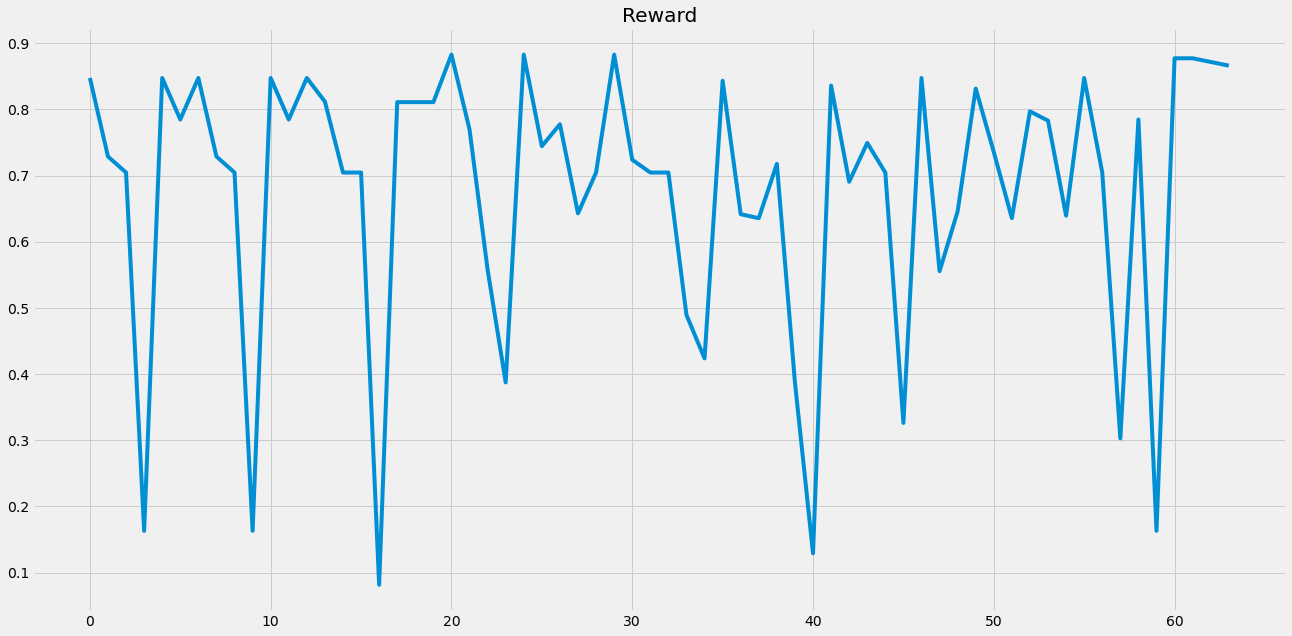

In [68]:
plt.title('Reward')
plt.plot(h_fill[14:])

In [46]:
frac_l = []
for i in range(len(h_fill[14:])):
    if h_fill[i+14] >= 0.3:
        frac_l.append(h_fill[i+14])

(0.0, 1.0)

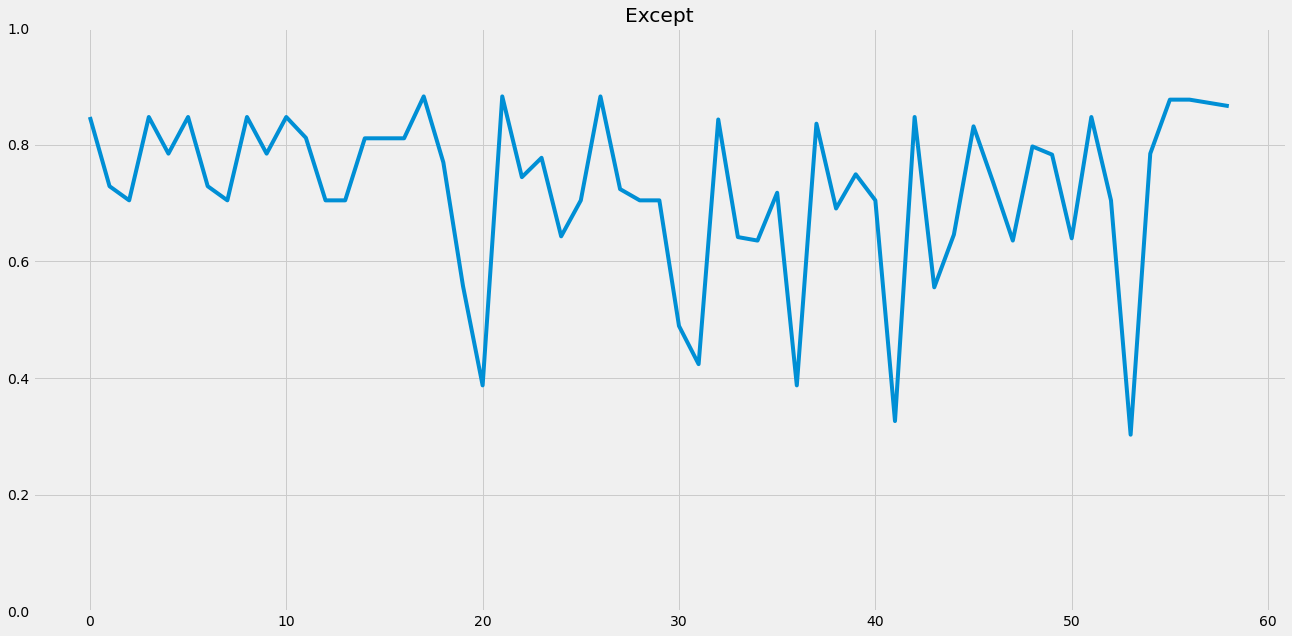

In [67]:
plt.title('Except')
plt.plot(frac_l)
plt.ylim([0,1])

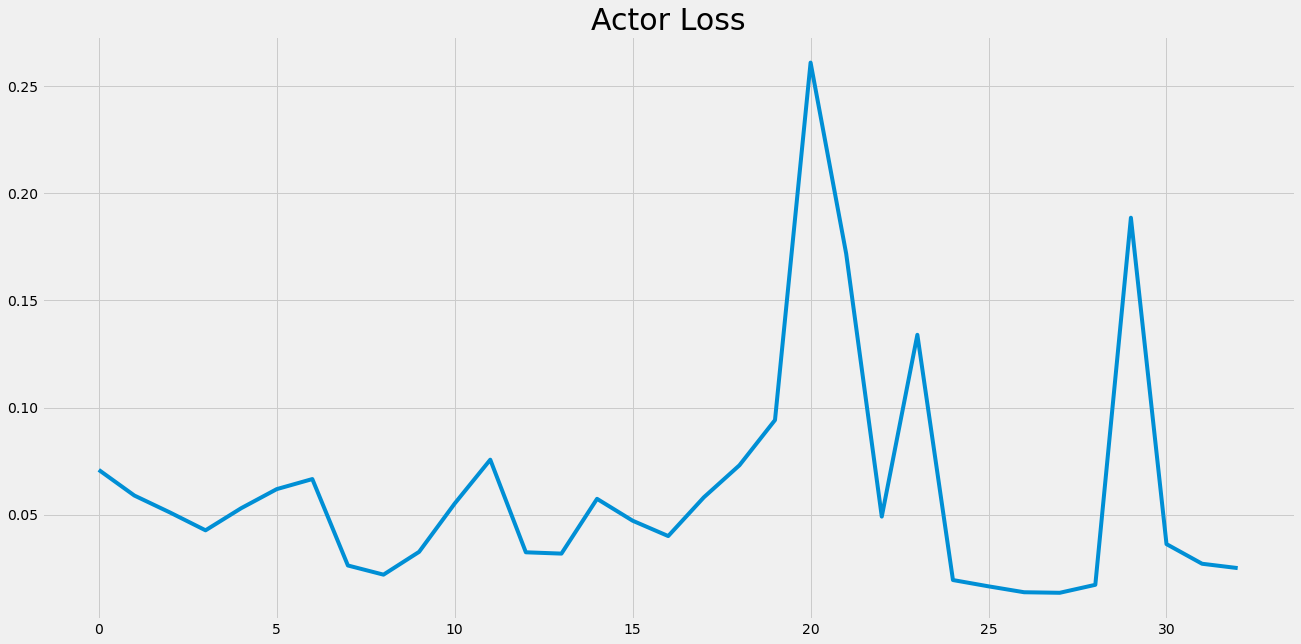

In [66]:
plt.title('Actor Loss', fontsize=30)
plt.plot(avg_actor_loss)

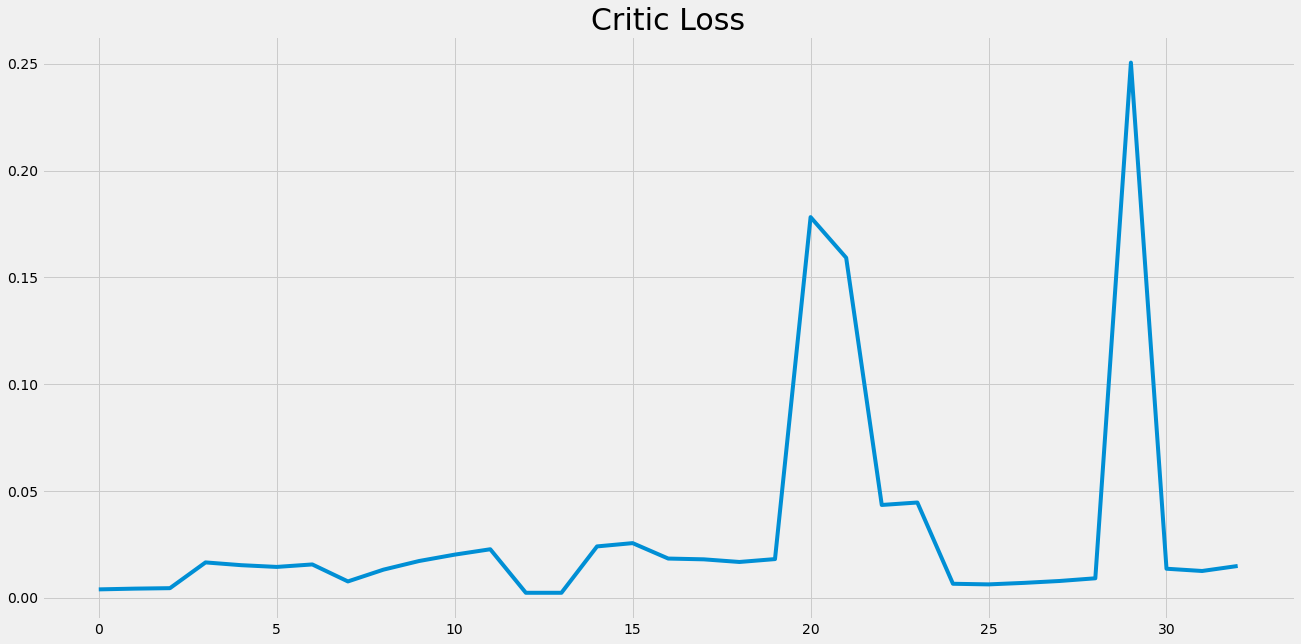

In [65]:
plt.title('Critic Loss', fontsize=30)
plt.plot(avg_critic_loss)

In [51]:
for i in range(13):
    print(boxes_multi[i])

[[56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [56 53 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]
 [47 35 24]]
[[106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [106  56  16]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 56  53  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]
 [ 47  35  24]


In [59]:
box_list = [np.array([56,53,24]), np.array([47,35,24]), np.array([106,56,16]),
           np.array([53,28,12]), np.array([27,21,12]), np.array([47,35,19]),
           np.array([37,35,16]), np.array([112,53,48]), np.array([53,28,24]),
           np.array([70,26,24]), np.array([112,26,24])]

In [ ]:
def vis_box(sizes,positions,fs=(3,3),mn=-5, mx=25):
    colors = get_colors(len(positions))
    fig = plt.figure(figsize=fs)
    ax = fig.gca(projection='3d')
    ax.set_aspect('auto')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([mn,mx])
    #ax.set_ylim([-5,25])
    ax.set_ylim([mx,mn])
    ax.set_zlim([mn,mx])
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.show()

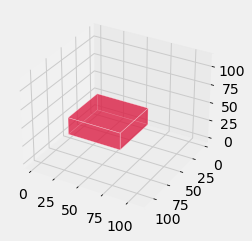

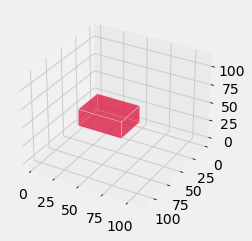

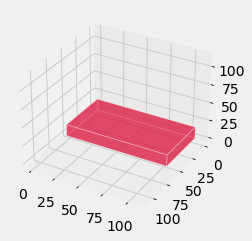

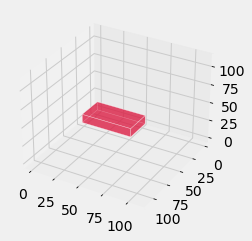

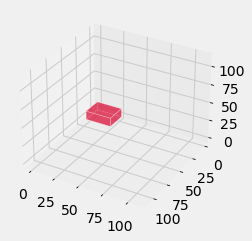

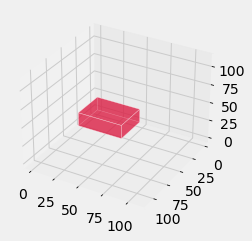

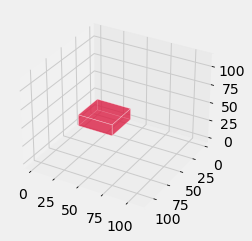

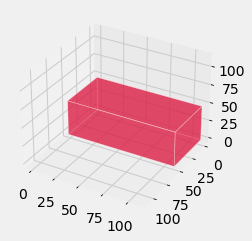

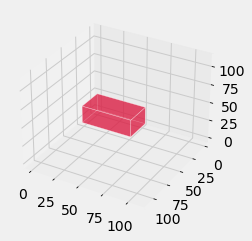

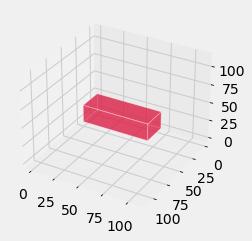

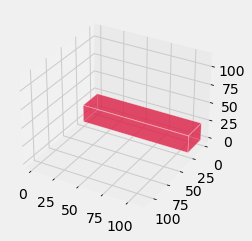

In [62]:
for box in box_list:
    vis_box([box], np.array([0,0,0]), mn=-5, mx=115)

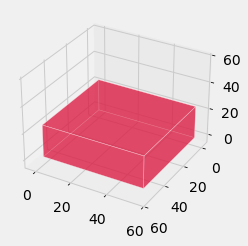

In [55]:
vis_box([boxes_multi[0][0]], np.array([0,0,0]), mn=-5, mx=60)